<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Application Programming Interface, Natural Language Processing & Classification Modelling

### Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Data-Visualization)

## Data Import and Cleaning

In [1]:
# import libraries
import pandas as pd
import numpy as np
import requests, time, nltk, string, re, os
import datetime as dt
from random import randint
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, plot_confusion_matrix, recall_score, precision_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier

import gensim.downloader as api #allows us to get word2vec anf glove embeddins that we need
from gensim.models.word2vec import Word2Vec

from bs4 import BeautifulSoup

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

In [2]:
btc_sub = pd.read_csv('../data/bitcoin_sub.csv')
eth_sub = pd.read_csv('../data/ethereum_sub.csv')

In [3]:
btc_sub.shape

(9998, 9)

In [4]:
btc_sub.head()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
0,Bitcoin,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],1626939006,theremnanthodl,True,1,0,2021-07-22
1,Bitcoin,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],1626938084,theremnanthodl,True,1,0,2021-07-22
2,Bitcoin,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",NaN,1626937970,ReadDailyCoin,False,1,1,2021-07-22
3,Bitcoin,Elon Musk’s View on Bitcoin (July 21 2021),NaN,1626937137,theloiteringlinguist,False,1,2,2021-07-22
4,Bitcoin,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin. But you can’t help but wonder what is it? What can I do with it? What is mining? Well CryptoMapz is...",NaN,1626936557,Electronic_Chard1987,False,1,20,2021-07-22


In [5]:
eth_sub.shape

(9999, 9)

In [6]:
eth_sub.head()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
0,ethereum,Should I sell bitcoin and just go all in ethereum?,"* I have like $37.5k invested total in bitcoin, and after the crash, I only have $10.8k gains. If I sold at $65k, I'd have $100k right now in cash.\n* I basically bought a whole coin at around $10...",1626938727,wuzzgucci,True,1,44,2021-07-22
1,ethereum,The hug – ultra rare 1/1,[removed],1626938319,Needle_NFT,True,1,0,2021-07-22
2,ethereum,L2BEAT website upgrade,[removed],1626938005,AOFEX__Official,True,1,0,2021-07-22
3,ethereum,The Internet World of our Future!!! (INSANE) the best vid I’ve ever watched in my life of crypto,NaN,1626937513,FarEnergy3518,False,1,0,2021-07-22
4,ethereum,I like the way Polygon thinks - Mihailo Bjelic on Twitter,NaN,1626936362,excusemealot,False,1,1,2021-07-22


#### Let's merge our submission dataframes to make processing easier

In [7]:
# concat the btc_sub & eth_sub dataframes
df = pd.concat([btc_sub, eth_sub])

In [8]:
df.shape

(19997, 9)

In [9]:
df.head()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
0,Bitcoin,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],1626939006,theremnanthodl,True,1,0,2021-07-22
1,Bitcoin,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],1626938084,theremnanthodl,True,1,0,2021-07-22
2,Bitcoin,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",NaN,1626937970,ReadDailyCoin,False,1,1,2021-07-22
3,Bitcoin,Elon Musk’s View on Bitcoin (July 21 2021),NaN,1626937137,theloiteringlinguist,False,1,2,2021-07-22
4,Bitcoin,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin. But you can’t help but wonder what is it? What can I do with it? What is mining? Well CryptoMapz is...",NaN,1626936557,Electronic_Chard1987,False,1,20,2021-07-22


In [10]:
df.tail()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
9994,ethereum,What’s the best way to save GAS Fees on ERC20 tokens? (If any),[removed],1620996867,Double_Concept2718,True,1,0,2021-05-14
9995,ethereum,HIGH PAYOUT AIRDROP,[removed],1620996293,Humanbot26,True,1,0,2021-05-14
9996,ethereum,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum.,NaN,1620995288,rollingincrypto,False,1,0,2021-05-14
9997,ethereum,I’m thinking about putting my entire life savings into ethereum. What do you guys think ?,[removed],1620994286,Resident-Lead2439,True,1,0,2021-05-14
9998,ethereum,mining eth with phoenix miner latest 5.6d getting HIGH stale rate,Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rate How can I lower the stale rate? everything is running stock and n...,1620994163,djsteveg,True,1,2,2021-05-14


#### Identifying the missing data

In [11]:
df.isnull().sum()

subreddit          0
title              0
selftext        9551
created_utc        0
author             0
is_self            0
score              0
num_comments       0
timestamp          0
dtype: int64

So now, we've identified that almost half selftext rows are null values. We can also see rows with (removed).

---

### Cleaning Strategy

1. Replace rows that have nulls in the 'selftext' column with blanks (' ')


2. Eliminate all rows in 'selftext' that are (removed) and (deleted)
    - Posts are usually (removed) by moderators or reddit itself when they do not conform to the regulations of the page
    - Hence, we have deemed that these posts may not be ideal to train our model since they're not deemed ideal by the page
    
    
3. We will proceed to create a merged column which will have the contents of the 'title' and 'selftext' columns
    - This allows us to form ONE single column to simplify future processes   


4. We will then remove any link references

#### 1. Replace nulls, (removed), and (deleted) in 'selftext' with blanks

In [12]:
df['selftext'] = df['selftext'].fillna('')

#df['selftext'] = df['selftext'].replace('[removed]', '')
#df['selftext'] = df['selftext'].replace('[deleted]', '')

#### 2. Eliminate rows in 'selftext' which contain (removed) and (deleted)

Dataframe shape BEFORE dropping rows with (removed) and (deleted)

In [13]:
df.shape

(19997, 9)

In [14]:
df = df[~df['selftext'].str.contains('removed|deleted', na=False)]

Dataframe shape AFTER dropping rows with (removed) and (deleted)

In [15]:
df.shape

(14046, 9)

After dropping almost 6,000 rows of data, we still are left with slightly more than 14,000 rows

In [16]:
df.head()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
2,Bitcoin,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",,1626937970,ReadDailyCoin,False,1,1,2021-07-22
3,Bitcoin,Elon Musk’s View on Bitcoin (July 21 2021),,1626937137,theloiteringlinguist,False,1,2,2021-07-22
4,Bitcoin,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin. But you can’t help but wonder what is it? What can I do with it? What is mining? Well CryptoMapz is...",,1626936557,Electronic_Chard1987,False,1,20,2021-07-22
5,Bitcoin,best crypto video ive ever watched,,1626936554,FarEnergy3518,False,1,2,2021-07-22
6,Bitcoin,what moves crypto market apart from the speculators,"I would like to know if there is anything that moves crypto market apart from the speculators, or are cryptocurrencies and their prices absolutely speculative?",1626936533,hawk-fe,True,1,7,2021-07-22


In [17]:
df.tail()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp
9989,ethereum,Is Ethereum only for the rich or do poor folks have any stake in it???,looking at Gas fees Ethereum feels like its only for rich first world crypto genius. Meanwhile poor people get Donations in shitcoins and Eth crowd screams \n\n# Vitalik donates $1 billion worth ...,1620998973,gravemindx,True,1,3,2021-05-14
9991,ethereum,I have been bitten by the bug,"When blockchain first came out I thought it would be a fad. Seeing that bitcoin really had no purpose besides store of value. Years go by and I find ethereum... I heard about it before, but I thou...",1620998600,moistcoder,True,1,58,2021-05-14
9993,ethereum,Well this is quite the story...,[https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html](https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html)\n\nFantasti...,1620997252,MikeClimbsDC,True,1,2,2021-05-14
9996,ethereum,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum.,,1620995288,rollingincrypto,False,1,0,2021-05-14
9998,ethereum,mining eth with phoenix miner latest 5.6d getting HIGH stale rate,Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rate How can I lower the stale rate? everything is running stock and n...,1620994163,djsteveg,True,1,2,2021-05-14


#### 3. Create a merged column 'alltext' which will have the contents of the 'title' and 'selftext' columns

In [18]:
# merge 'title' and 'selftext' content into 'alltext'
df['alltext'] = df['title'] + '. ' + df['selftext']

In [19]:
df.tail()

,subreddit,title,selftext,created_utc,author,is_self,score,num_comments,timestamp,alltext
9989,ethereum,Is Ethereum only for the rich or do poor folks have any stake in it???,looking at Gas fees Ethereum feels like its only for rich first world crypto genius. Meanwhile poor people get Donations in shitcoins and Eth crowd screams \n\n# Vitalik donates $1 billion worth ...,1620998973,gravemindx,True,1,3,2021-05-14,Is Ethereum only for the rich or do poor folks have any stake in it???. looking at Gas fees Ethereum feels like its only for rich first world crypto genius. Meanwhile poor people get Donations in ...
9991,ethereum,I have been bitten by the bug,"When blockchain first came out I thought it would be a fad. Seeing that bitcoin really had no purpose besides store of value. Years go by and I find ethereum... I heard about it before, but I thou...",1620998600,moistcoder,True,1,58,2021-05-14,I have been bitten by the bug. When blockchain first came out I thought it would be a fad. Seeing that bitcoin really had no purpose besides store of value. Years go by and I find ethereum... I he...
9993,ethereum,Well this is quite the story...,[https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html](https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html)\n\nFantasti...,1620997252,MikeClimbsDC,True,1,2,2021-05-14,Well this is quite the story.... [https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html](https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptoc...
9996,ethereum,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum.,,1620995288,rollingincrypto,False,1,0,2021-05-14,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum..
9998,ethereum,mining eth with phoenix miner latest 5.6d getting HIGH stale rate,Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rate How can I lower the stale rate? everything is running stock and n...,1620994163,djsteveg,True,1,2,2021-05-14,mining eth with phoenix miner latest 5.6d getting HIGH stale rate. Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rat...


After merging 'title' and 'selftext' into 'alltext', we drop those two columns, and move 'alltext' to beside 'subreddit'

In [20]:
df = df.drop(['title', 'selftext'], axis=1)
df = df[['subreddit', 'alltext', 'created_utc', 'author', 'is_self', 'score', 'num_comments', 'timestamp']]

In [21]:
df.tail()

,subreddit,alltext,created_utc,author,is_self,score,num_comments,timestamp
9989,ethereum,Is Ethereum only for the rich or do poor folks have any stake in it???. looking at Gas fees Ethereum feels like its only for rich first world crypto genius. Meanwhile poor people get Donations in ...,1620998973,gravemindx,True,1,3,2021-05-14
9991,ethereum,I have been bitten by the bug. When blockchain first came out I thought it would be a fad. Seeing that bitcoin really had no purpose besides store of value. Years go by and I find ethereum... I he...,1620998600,moistcoder,True,1,58,2021-05-14
9993,ethereum,Well this is quite the story.... [https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptocurrency-bitcoin.html](https://www.nytimes.com/2021/05/14/podcasts/the-daily/dogecoin-cryptoc...,1620997252,MikeClimbsDC,True,1,2,2021-05-14
9996,ethereum,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum..,1620995288,rollingincrypto,False,1,0,2021-05-14
9998,ethereum,mining eth with phoenix miner latest 5.6d getting HIGH stale rate. Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rat...,1620994163,djsteveg,True,1,2,2021-05-14


Find out number of words in the alltext column

In [22]:
def word_count(series):
    list_tokens = [w.lower() for w in series]
    string_tokens = str(list_tokens)
    tokens = BeautifulSoup(string_tokens).get_text()
    return tokens
len(word_count(df['alltext']).split())

585907

#### 4. Remove link references

In [23]:
# remove anything which has http, www, &amp as they usually part of a url
df['alltext'] = df['alltext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'\&amp\S+', '', regex=True)

In [24]:
df.tail()

,subreddit,alltext,created_utc,author,is_self,score,num_comments,timestamp
9989,ethereum,Is Ethereum only for the rich or do poor folks have any stake in it???. looking at Gas fees Ethereum feels like its only for rich first world crypto genius. Meanwhile poor people get Donations in ...,1620998973,gravemindx,True,1,3,2021-05-14
9991,ethereum,I have been bitten by the bug. When blockchain first came out I thought it would be a fad. Seeing that bitcoin really had no purpose besides store of value. Years go by and I find ethereum... I he...,1620998600,moistcoder,True,1,58,2021-05-14
9993,ethereum,"Well this is quite the story.... [\n\nFantastic for him, and glad his roulette wheel paid off. But Doge is the future of crypto? Not sure I agree with that one...",1620997252,MikeClimbsDC,True,1,2,2021-05-14
9996,ethereum,Singapore’s DBS Private Bank has announced the launch of Asia’s first bank-backed trust offering for cryptocurrency including Ethereum..,1620995288,rollingincrypto,False,1,0,2021-05-14
9998,ethereum,mining eth with phoenix miner latest 5.6d getting HIGH stale rate. Hey everybody! I have a 5600x with a 580 rx and 32gigs of DDR4 mining ethereum using phoenix mine and I have a 44%-50% stale rat...,1620994163,djsteveg,True,1,2,2021-05-14


Checking that all html links have been removed. Viola!

---

### Pre-processing the data:

1. Lowercase all words and split words into individual tokens
2. Lemmatize words that are not stopwords (Not stemming because we prefer accuracy over speed)

In [25]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [26]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatizing and stopwords exclusion within the same step
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    text = (' '.join(text))
    return text

In [27]:
df['alltext'] = df['alltext'].apply(lambda x: clean_text(x))

In [28]:
df.tail()

,subreddit,alltext,created_utc,author,is_self,score,num_comments,timestamp
9989,ethereum,ethereum rich poor folk stake looking gas fee ethereum feel like rich first world crypto genius meanwhile poor people get donation shitcoins eth crowd scream vitalik donates 1 billion worth shiba ...,1620998973,gravemindx,True,1,3,2021-05-14
9991,ethereum,bitten bug blockchain first came thought would fad seeing bitcoin really purpose besides store value year go find ethereum heard thought another type blockchain like bitcoin gave time day whole op...,1620998600,moistcoder,True,1,58,2021-05-14
9993,ethereum,well quite story fantastic glad roulette wheel paid doge future crypto sure agree one,1620997252,MikeClimbsDC,True,1,2,2021-05-14
9996,ethereum,singapore db private bank announced launch asia first bankbacked trust offering cryptocurrency including ethereum,1620995288,rollingincrypto,False,1,0,2021-05-14
9998,ethereum,mining eth phoenix miner latest 56d getting high stale rate hey everybody 5600x 580 rx 32gigs ddr4 mining ethereum using phoenix mine 4450 stale rate lower stale rate everything running stock oc,1620994163,djsteveg,True,1,2,2021-05-14


---

## Exploratory Data Analysis

Let's try to understand the usefulness of our content by analysing the volume of comments and the richness of the text

#### Distribution of posts by volume of comments

In [29]:
df['num_comments'].value_counts()[:50]

0     4927
1     1774
2     1073
3      683
4      605
5      438
6      393
7      296
8      288
9      259
10     230
11     192
12     184
13     163
14     142
15     128
16     124
17      99
19      93
18      89
22      75
20      74
21      69
23      65
24      59
26      55
25      53
27      51
29      49
28      46
31      38
32      32
33      32
30      29
41      29
36      26
39      25
34      25
35      25
44      23
40      23
37      23
47      22
57      19
45      19
38      19
52      19
42      19
43      17
64      16
Name: num_comments, dtype: int64

In [30]:
print('Average No. of Comments: ', df['num_comments'].mean())
print('Most Frequent No. of Comments: ', df['num_comments'].mode())
print('Maximum No. of Comments on a Post: ', df['num_comments'].max())

Average No. of Comments:  15.804214723052826
Most Frequent No. of Comments:  0    0
dtype: int64
Maximum No. of Comments on a Post:  1629


Most posts have no comments. The average number of comments across all posts is 18, with some outliers exceeding 1,000 comments that can could either add noise to the model or they could also indicate the popularity of particular posts. For now, we're not going to remove it even though it may skew our data, because it may still turn out to be useful.

## Data Visualization

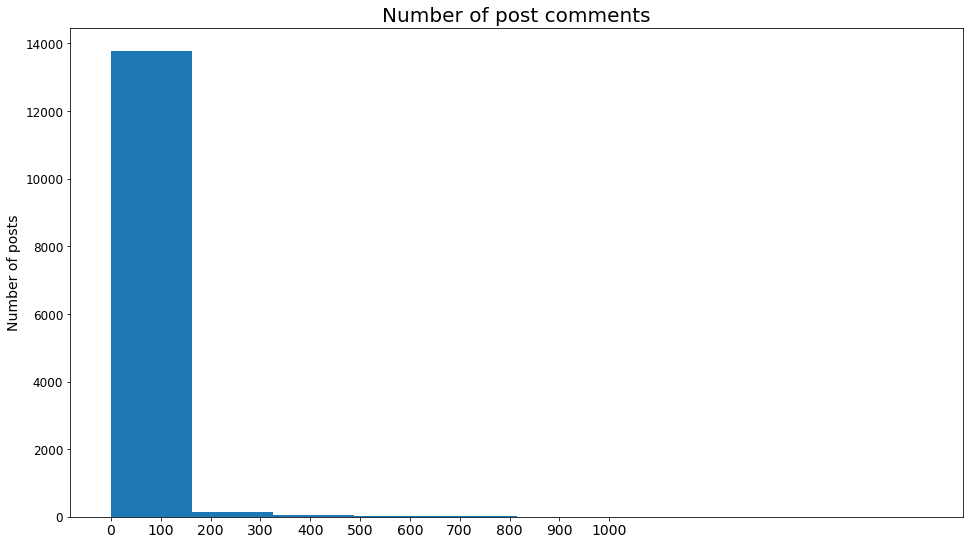

In [31]:
plt.figure(figsize = (16,9));
df['num_comments'].plot(kind='hist');
plt.title('Number of post comments', size =20);
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], size=14);
plt.yticks(size=12);
plt.ylabel('Number of posts', size=14);

Let's see if any authors appear too frequently. It might either mean that they're very active on Reddit or could be spam

In [32]:
df['author'].value_counts()[:50]

twigwam                 195
simplelifestyle         108
Zalkifl_Savage           87
rollingincrypto          62
TobiHovey                58
coinmonks                52
hamoti                   50
[deleted]                49
CoinjoyAssistant         49
DailyGweiBot             47
PeacockMamba             46
crypto_pub               43
Grade19282               42
sportifynews             42
AutoModerator            39
rBitcoinMod              39
shaikhzahida             37
the_damj                 36
CryptoDeFinance          36
BoyYeetzWorld            35
CorrineSomers            35
fecktk                   34
BitcoinWide              33
Major_Bandicoot_3239     33
nicky_papagiorgio        33
ShotBot                  33
VeronZ76                 33
ARONBOSS                 32
sylsau                   32
bletchleymcgregor        31
fritson1                 31
ligi                     30
thefoodboylover          30
michalesalla             29
BashCo                   29
Mars_chego          

In [33]:
print('Total No. of Unique Authors: ', len(df['author'].unique()))
print('Average No. of Posts by Authors: ', df['author'].value_counts().mean())

Total No. of Unique Authors:  7772
Average No. of Posts by Authors:  1.8072568193515182


Let's see how many posts we've had over the months

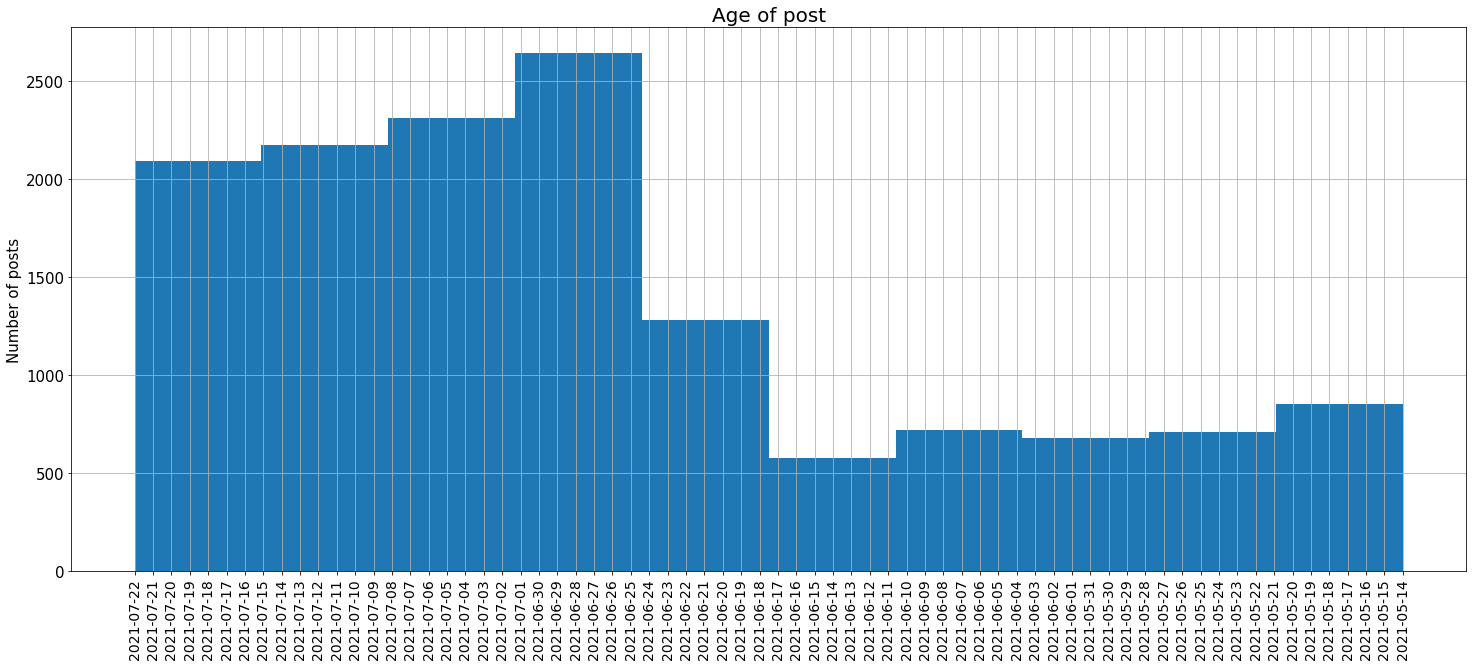

In [34]:
plt.figure(figsize = (25,10))
plt.title('Age of post', size = 20);
df['timestamp'].hist();
plt.xticks(size=14, rotation=90)
plt.yticks(size=15)
plt.ylabel('Number of posts', size = 15);

Number of posts from 14th May to 17th June was fairly low and consistent until a sudden jump on 18th June, and then again on 25th June.

The period from 18th June to 1st July 2021 coincides with negative fluctuation in Bitcoin and Ethereum prices, possibly leading to a lot of chatter on the subreddits.

Distribution of original posts vs reposts

In [35]:
df['is_self'].value_counts(normalize=True).round(2)

False    0.65
True     0.35
Name: is_self, dtype: float64

How well do most posts score?

This is derived from (Total Upvotes - Total Downvotes) on a post.

Higher positive score indicates a post deemed to be of better quality due to a larger positive difference between upvotes and downvotes.

In [36]:
print('Average Post Score: ', df['score'].mean())
print('Highest Post Score: ', df['score'].max())

Average Post Score:  1.9874697422753809
Highest Post Score:  1998


#### Vectorize text in prep for analysis
We will need to vectorize our words, for our models to process them

In [37]:
# initialise countvectorizer
cvec = CountVectorizer()
# fit and transform vectorizer
word_counts = cvec.fit_transform(df['alltext'])

In [38]:
type(word_counts)

scipy.sparse.csr.csr_matrix

In [39]:
# make it a dataframe
counts = pd.DataFrame(word_counts.todense(), columns=cvec.get_feature_names())

In [40]:
print('Total No. of Words in the Post Column: ', counts.sum().sum())

Total No. of Words in the Post Column:  323988


Create a new column 'post_length' that calculates words contained in each 'alltext' row

In [41]:
df['post_length'] = df['alltext'].map(lambda x: len(x.split()))

In [42]:
df.sort_values(by='alltext', ascending=False).head()

,subreddit,alltext,created_utc,author,is_self,score,num_comments,timestamp,post_length
2142,ethereum,𝚆𝚎𝚕𝚕 𝚘𝚔 𝚝𝚑𝚎𝚗,1625352452,VelothYT,False,1,13,2021-07-04,3
1074,Bitcoin,𝗠𝗗𝗧 𝗣𝗿𝗶𝘃𝗮𝘁𝗲 𝗦𝗮𝗹𝗲 𝗢𝗻𝗴𝗼𝗶𝗻𝗴,1626678829,Zuchiii,False,1,0,2021-07-19,4
8853,Bitcoin,加密货币的寒冬到来了吗,1624629610,jcj52,False,1,0,2021-06-25,1
4267,ethereum,以太坊上的域名服务 en 让你拥有自己独特的钱包地址 轻松得到v神钱包地址,1623863082,Psychological-One788,False,1,0,2021-06-17,4
9994,Bitcoin,中国全面封杀比特币 各大银行联合声明禁止 牛市彻底结束了吗 为什么中国年年禁止比特币,1624395628,Psychological-One788,False,1,4,2021-06-23,4


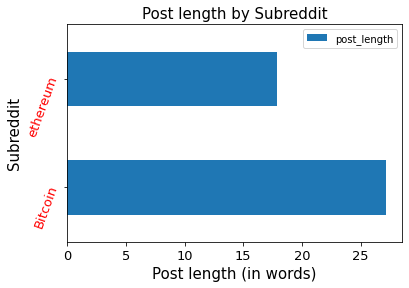

In [43]:
# think about whether this info is valuable

df.groupby('subreddit')[['post_length']].mean().plot(kind='barh');
plt.xticks(size=13);
plt.yticks(size=13, rotation = 70, color = 'red'); #rotation added in order to fit labels
plt.ylabel('Subreddit', size=15)
plt.xlabel('Post length (in words)', size=15);
plt.title('Post length by Subreddit', size=15);

What are the most common words?

In [44]:
type(counts)

pandas.core.frame.DataFrame

In [45]:
counts.sum().sort_values(ascending=False).head(50).T

bitcoin           8036
crypto            2491
ethereum          2407
btc               2158
eth               1709
like              1685
would             1638
get               1484
wallet            1462
price             1456
time              1361
people            1301
one               1292
money             1204
know              1194
buy               1086
new               1062
im                1050
make              1044
year              1006
mining             984
market             971
use                963
coin               920
transaction        911
want               887
need               884
think              875
network            875
dont               848
could              845
day                800
way                787
go                 784
see                777
first              771
help               752
blockchain         747
fee                740
also               733
good               702
currency           694
exchange           692
even       

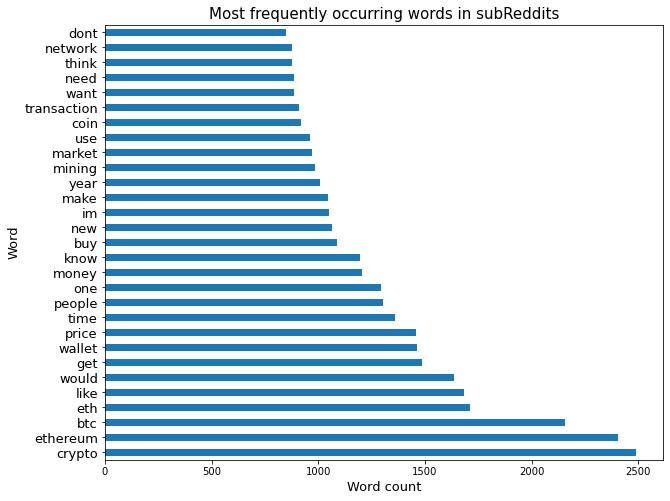

In [46]:
plt.figure(figsize=(10,8))
counts.sum().sort_values(ascending=False).head(30)[1:].plot(kind='barh');
plt.title('Most frequently occurring words in subReddits', size = 15);
plt.xlabel('Word count', size =13);
plt.yticks(size=13);
plt.ylabel('Word', size=13);

In [47]:
df.to_csv('../data/df_sub.csv', index=False)

In [48]:
df.isnull().sum()

subreddit       0
alltext         0
created_utc     0
author          0
is_self         0
score           0
num_comments    0
timestamp       0
post_length     0
dtype: int64

In [49]:
df.shape

(14046, 9)